In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [53]:
hosp_test = pd.read_csv("hospitalizaciones_test.csv")
hosp_train = pd.read_csv("hospitalizaciones_train.csv")

## NORMALIZACION ##

Elimino columnas que considero innecesarias. Luego transformo a valor numérico las variables categóricas para trabajar con ellas:

In [54]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()

# Primero en train

# Dropeo columnas
hosp_train.drop(['Available Extra Rooms in Hospital'], axis=1, inplace=True)
hosp_train.drop(['staff_available'], axis=1, inplace=True)
hosp_train.drop(['patientid'], axis=1, inplace=True)
hosp_train.drop(['Visitors with Patient'], axis=1, inplace=True)
hosp_train.drop(['Ward_Facility_Code'], axis=1, inplace=True)
hosp_train.drop(['doctor_name'], axis=1, inplace=True)

# Transformo
hosp_train['Department_le'] = le.fit_transform(hosp_train['Department'])
hosp_train.drop(['Department'], axis=1, inplace=True)

hosp_train['Age_le'] = le.fit_transform(hosp_train['Age'])
hosp_train.drop(['Age'], axis=1, inplace=True)

hosp_train['gender_le'] = le.fit_transform(hosp_train['gender'])
hosp_train.drop(['gender'], axis=1, inplace=True)

hosp_train['Type of Admission_le'] = le.fit_transform(hosp_train['Type of Admission'])
hosp_train.drop(['Type of Admission'], axis=1, inplace=True)

hosp_train['Severity of Illness_le'] = le.fit_transform(hosp_train['Severity of Illness'])
hosp_train.drop(['Severity of Illness'], axis=1, inplace=True)

hosp_train['health_conditions_le'] = le.fit_transform(hosp_train['health_conditions'])
hosp_train.drop(['health_conditions'], axis=1, inplace=True)

hosp_train['Insurance_le'] = le.fit_transform(hosp_train['Insurance'])
hosp_train.drop(['Insurance'], axis=1, inplace=True)


In [55]:
# Ahora en test

# Dropeo columnas
hosp_test.drop(['Available Extra Rooms in Hospital'], axis=1, inplace=True)
hosp_test.drop(['staff_available'], axis=1, inplace=True)
hosp_test.drop(['patientid'], axis=1, inplace=True)
hosp_test.drop(['Visitors with Patient'], axis=1, inplace=True)
hosp_test.drop(['Ward_Facility_Code'], axis=1, inplace=True)
hosp_test.drop(['doctor_name'], axis=1, inplace=True)

# Transformo
hosp_test['Department_le'] = le.fit_transform(hosp_test['Department'])
hosp_test.drop(['Department'], axis=1, inplace=True)

hosp_test['Age_le'] = le.fit_transform(hosp_test['Age'])
hosp_test.drop(['Age'], axis=1, inplace=True)

hosp_test['gender_le'] = le.fit_transform(hosp_test['gender'])
hosp_test.drop(['gender'], axis=1, inplace=True)

hosp_test['Type of Admission_le'] = le.fit_transform(hosp_test['Type of Admission'])
hosp_test.drop(['Type of Admission'], axis=1, inplace=True)

hosp_test['Severity of Illness_le'] = le.fit_transform(hosp_test['Severity of Illness'])
hosp_test.drop(['Severity of Illness'], axis=1, inplace=True)

hosp_test['health_conditions_le'] = le.fit_transform(hosp_test['health_conditions'])
hosp_test.drop(['health_conditions'], axis=1, inplace=True)

hosp_test['Insurance_le'] = le.fit_transform(hosp_test['Insurance'])
hosp_test.drop(['Insurance'], axis=1, inplace=True)

Creo nueva variable categórica para clasificar estancias largas

In [56]:
hosp_train['Estancia_prolongada'] = np.where(hosp_train['Stay (in days)']<9, 0, 1)

#Elimino la columna con los días que no voy a usar
hosp_train.drop(['Stay (in days)'], axis=1, inplace=True)

## BUSCO RELACIONES CON MI VARIABLE OBJETIVO ##

Busco correlaciones, grafico para tener ayuda visual

In [57]:
def plot_corre_heatmap(corr):
    '''
    Definimos una función para ayudarnos a graficar un heatmap de correlación
    '''
    plt.figure(figsize=(12,10))
    sns.heatmap(corr, cbar = True,  square = False, annot=True, fmt= '.2f'
                ,annot_kws={'size': 15},cmap= 'coolwarm')
    plt.xticks(rotation = 45)
    plt.yticks(rotation = 45)
    # Arreglamos un pequeño problema de visualización
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

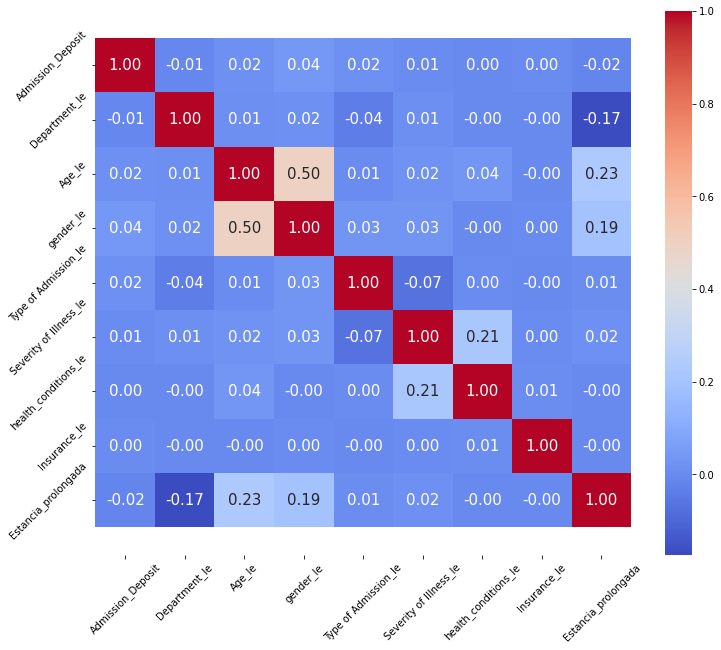

In [58]:
corr = hosp_train.corr()
plot_corre_heatmap(corr)

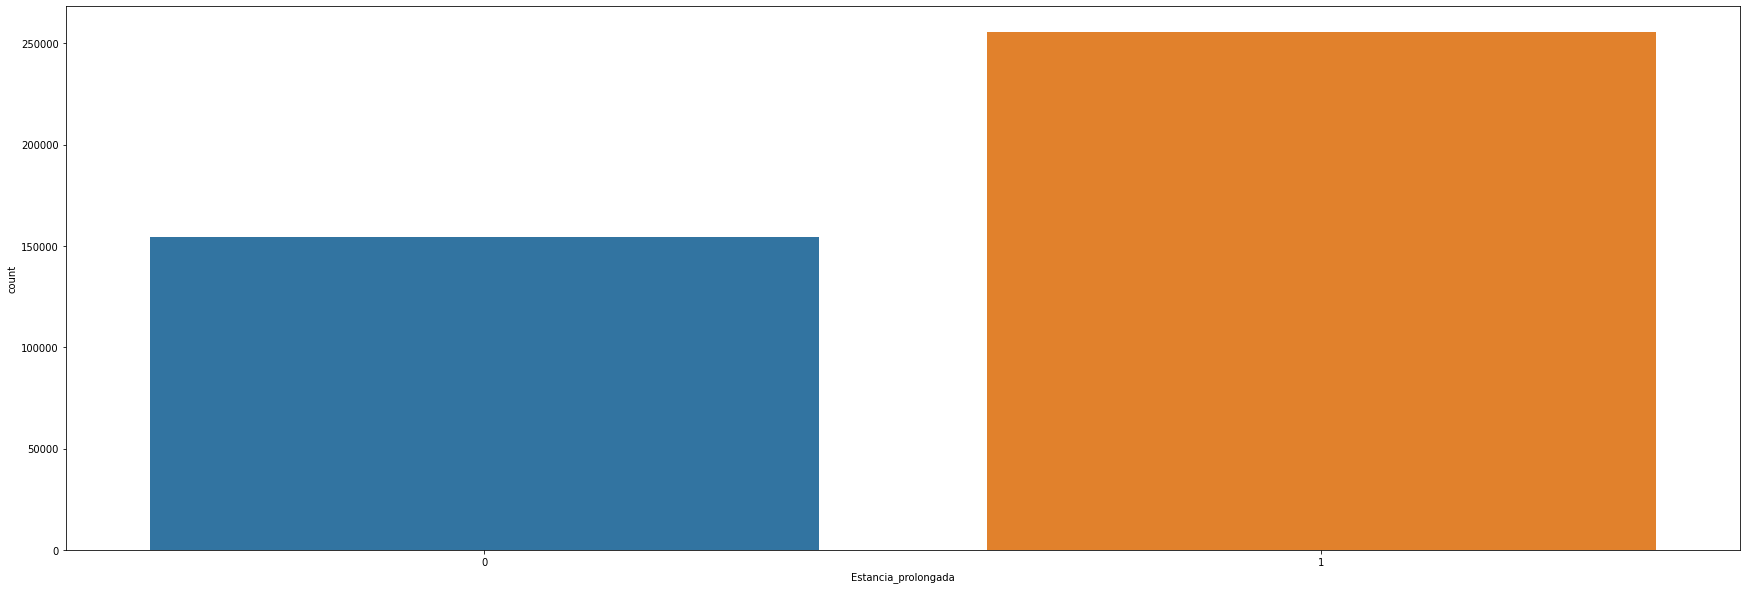

In [59]:
# Miro si mi dataset esta balanceado
sns.countplot(x='Estancia_prolongada', data=hosp_train)
plt.show()

Utilizo KBest para encontrar los features mas relacionados a mi objetivo

In [60]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import mutual_info_classif

In [61]:
selector = SelectKBest(mutual_info_regression, k=4)

X = hosp_train.drop(['Estancia_prolongada'], axis=1)
                
y = hosp_train[['Estancia_prolongada']]

selector.fit(X,y)

C:\Users\ronal\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\utils\validation.py:1111: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SelectKBest(k=4,
            score_func=<function mutual_info_regression at 0x0000016EC76A0550>)

Ploteo para tener ayuda visual

In [62]:
scores = selector.scores_
list(X.columns)

['Admission_Deposit',
 'Department_le',
 'Age_le',
 'gender_le',
 'Type of Admission_le',
 'Severity of Illness_le',
 'health_conditions_le',
 'Insurance_le']

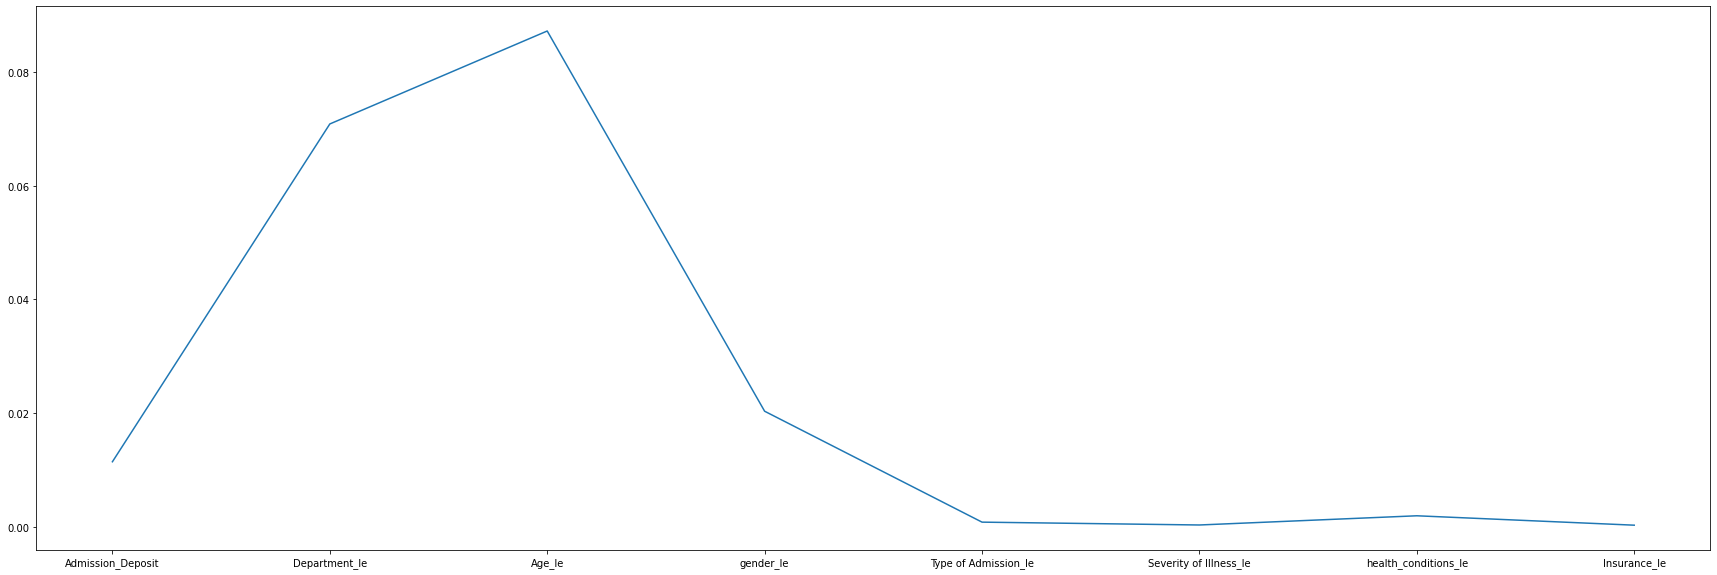

In [63]:
plt.rcParams["figure.figsize"] = [30,10]
plt.plot(scores)
plt.xticks(np.arange(8),list(X.columns));

## CREO MODELO DE ML ##

• Encontradas mis features 'Age', 'Department', separo el Dataset para entrenar el modelo

In [64]:
from sklearn.model_selection import train_test_split
X = hosp_train[['Department_le', 'Age_le']]                
y = hosp_train[['Estancia_prolongada']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

• Busco los hiperparámetros adecuados para mi dataset

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

tree_para = {'criterion':['gini','entropy'],'max_depth':[2,3,4,5,6,7,8]}#, 'min_samples_split':[0.05,0.10], 'min_samples_leaf':[0.05,0.10]}
model_1 = GridSearchCV(DecisionTreeClassifier(), tree_para, cv=10, scoring = 'accuracy') #'precision' #'recall'

In [70]:
model_1.fit(X_train, y_train)

GridSearchCV(cv=10, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8]},
             scoring='accuracy')

In [71]:
# Predecimos sobre nuestro set de test
     
y_test_pred = model_1.predict(X_test)


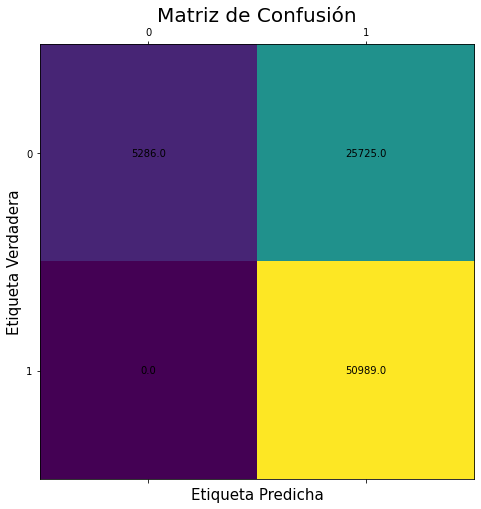

In [72]:
# Matriz de confusión 

from sklearn.metrics import confusion_matrix, classification_report
cm = confusion_matrix(y_test, y_test_pred)

fig, ax = plt.subplots(figsize=(12,8))
ax.matshow(cm)
plt.title('Matriz de Confusión', fontsize=20)
plt.ylabel('Etiqueta Verdadera', fontsize=15)
plt.xlabel('Etiqueta Predicha', fontsize=15)
for (i, j), z in np.ndenumerate(cm):
    ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

In [74]:
from sklearn.metrics import classification_report

#Analizamos el reporte de clasificación (podemos observar el recall y accuracy)
report = classification_report(y_test, y_test_pred)
print("Reporte de Clasificación:")
print(report)

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       1.00      0.17      0.29     31011
           1       0.66      1.00      0.80     50989

    accuracy                           0.69     82000
   macro avg       0.83      0.59      0.54     82000
weighted avg       0.79      0.69      0.61     82000



In [75]:
pred = pd.DataFrame(list(y_test_pred), columns=['pred'])

In [76]:
pred.to_csv('ronalcabrera.csv', index=False, sep=',')

In [76]:
hosp_test

,Available Extra Rooms in Hospital,staff_available,patientid,Visitors with Patient,Admission_Deposit,Department_le,Ward_Facility_Code_le,doctor_name_le,Age_le,gender_le,Type of Admission_le,Severity of Illness_le,health_conditions_le,Insurance_le
0,3,10,2858,2,4749.640225,2,5,4,2,0,1,2,5,0
1,2,4,65657,2,4122.261324,0,4,1,5,0,1,2,0,1
2,2,7,45598,3,5459.067882,3,4,1,5,2,1,2,4,0
3,2,1,31132,2,3987.033318,2,5,4,2,0,1,2,4,1
4,2,7,125021,2,4770.789695,1,0,1,5,0,1,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89995,4,2,43001,3,4105.795901,2,5,6,1,0,1,1,3,0
89996,13,8,85601,2,4631.550257,2,5,4,3,0,0,2,5,0
89997,2,3,22447,2,5456.930075,2,1,6,1,0,0,2,3,0
89998,2,1,29957,2,4694.127772,3,0,1,6,0,1,0,1,0
